[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cast42/bayesian/blob/master/PyMC_Demo.ipynb)

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import aesara.tensor as at
from IPython.display import Video

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.4.0


In [3]:
# Initialize random number generator
RANDOM_SEED = 1301
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Bayesian regression

Fraom https://github.com/pymc-devs/pymc-data-umbrella/blob/main/about/probabilistic_programming_with_pymc/notebook.ipynb

In [4]:
# Anscombe's quartet III
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5], dtype=np.float64)
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

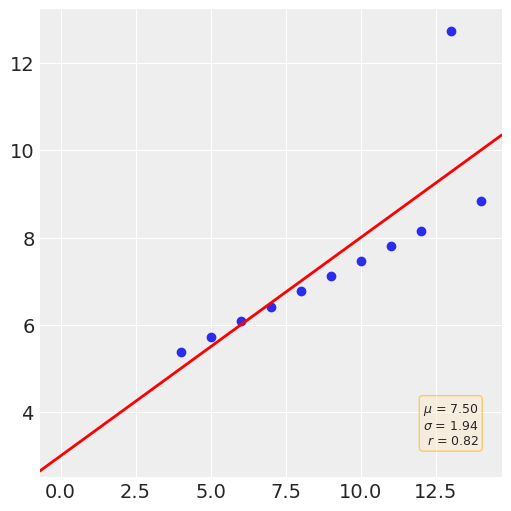

In [5]:
  fig, ax = plt.subplots(figsize=(5,5))

  ax.tick_params(direction='in', top=True, right=True)
  ax.plot(x, y3, 'o')

  # linear regression
  p1, p0 = np.polyfit(x, y3, deg=1)  # slope, intercept
  ax.axline(xy1=(0, p0), slope=p1, color='r', lw=2)

  # add text box for the statistics
  stats = (f'$\\mu$ = {np.mean(y3):.2f}\n'
            f'$\\sigma$ = {np.std(y3):.2f}\n'
            f'$r$ = {np.corrcoef(x, y3)[0][1]:.2f}')
  bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
  ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
          transform=ax.transAxes, horizontalalignment='right');

#### Ordinary least squares

**Assumption:** All values of $m, b \in \mathbb{R}$, $\sigma > 0$ are equally likely

In [6]:
with pm.Model() as ols_model:
    m = pm.Flat("m")
    b = pm.Flat("b")

    σ = pm.HalfFlat("σ")

$$y\ |\ x = m x + b + \varepsilon,\ \varepsilon \sim N(0, \sigma^2)$$

This is equivalent to

$$y\ |\ x \sim N(m x + b, \sigma^2)$$

In [7]:
with ols_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)

In [8]:
with ols_model:
    ols_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


### Check output and model

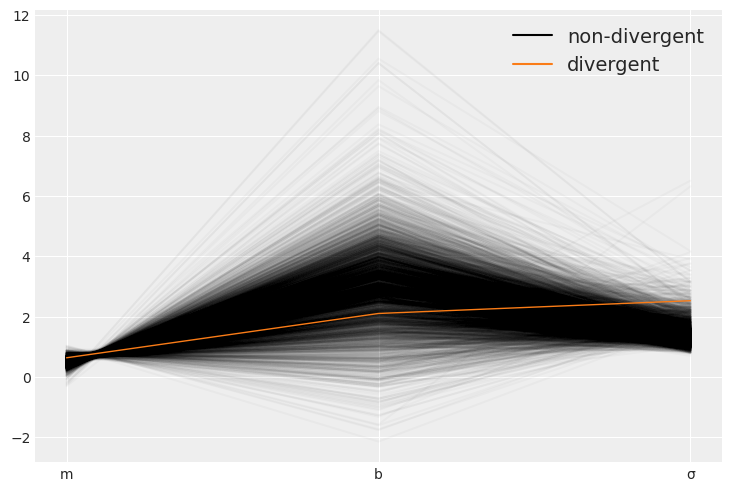

In [9]:
az.plot_parallel(ols_trace);

In [10]:
az.bfmi(ols_trace)

array([0.76485113, 0.9354235 , 1.05958797, 0.97610958])

<AxesSubplot: >

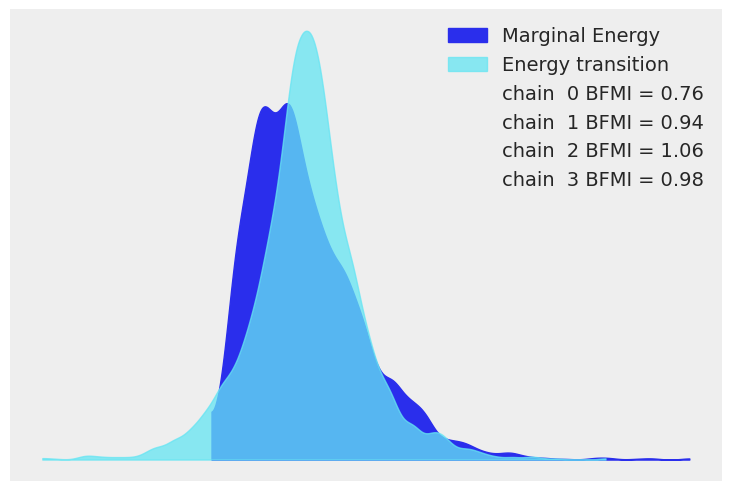

In [11]:
az.plot_energy(ols_trace)

In [12]:
az.summary(ols_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.497,0.146,0.251,0.799,0.006,0.004,820.0,802.0,1.01
b,3.042,1.389,0.301,5.533,0.054,0.047,828.0,741.0,1.01
σ,1.448,0.428,0.815,2.192,0.014,0.010,1015.0,1137.0,1.01


In [13]:
with ols_model:
    ppc = pm.sample_posterior_predictive(ols_trace, extend_inferencedata=True)

Sampling: [y_obs]


<AxesSubplot: xlabel='y_obs / y_obs'>

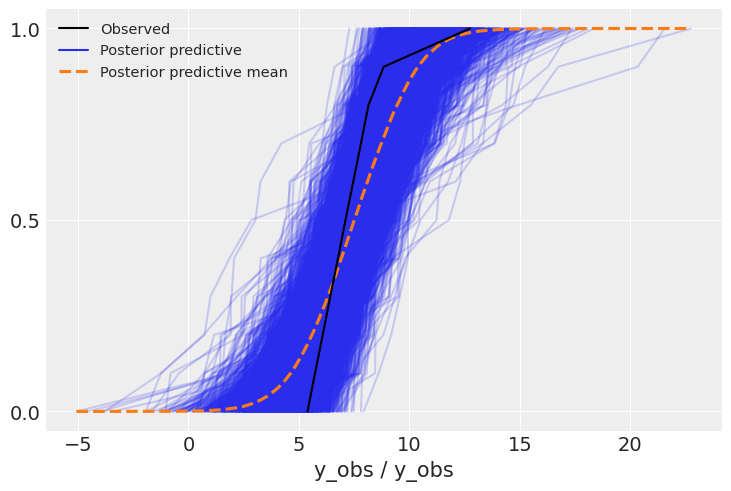

In [14]:
az.plot_ppc(ppc, kind="cumulative");

### Plot the model output

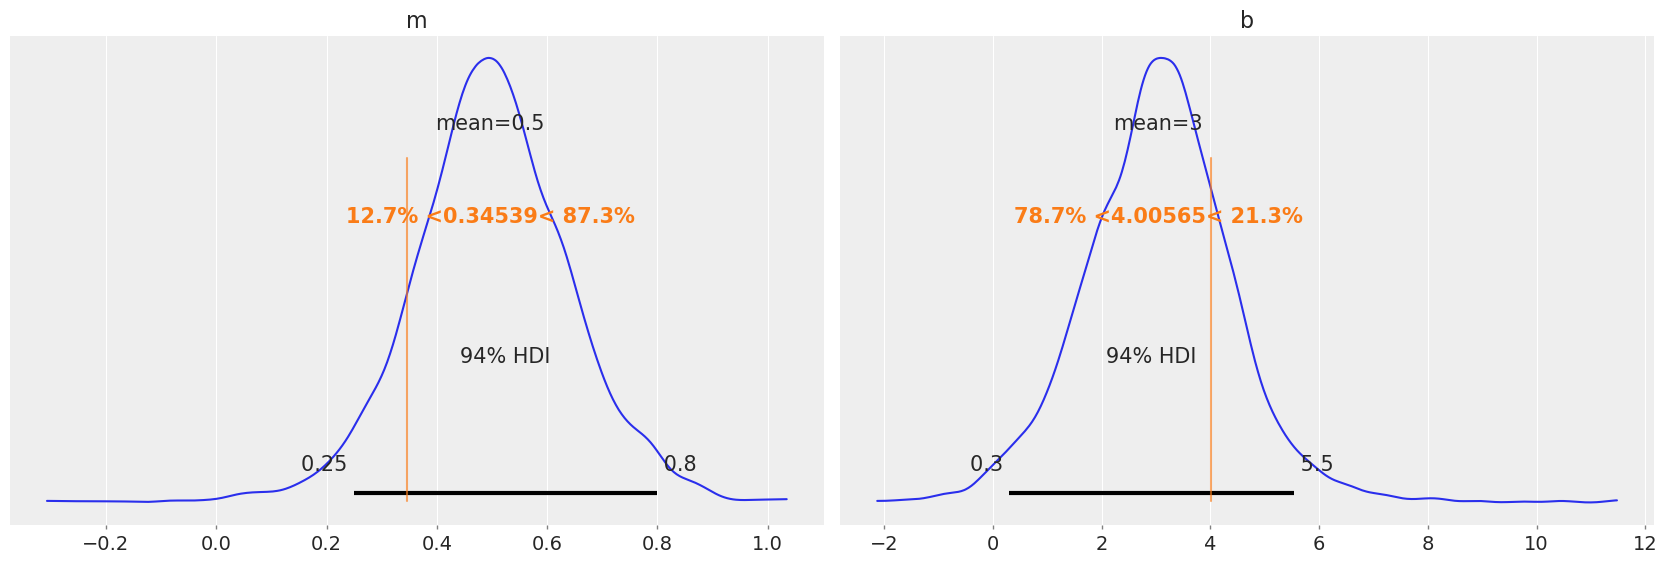

In [15]:
m_robust, b_robust = np.polyfit(x[x != 13], y3[x != 13], deg=1) 

az.plot_posterior(ols_trace, var_names=["m", "b"],
                  ref_val=[m_robust, b_robust]);

# Bayesian evaluation of a traffic safety intervention

## Data of the experiment

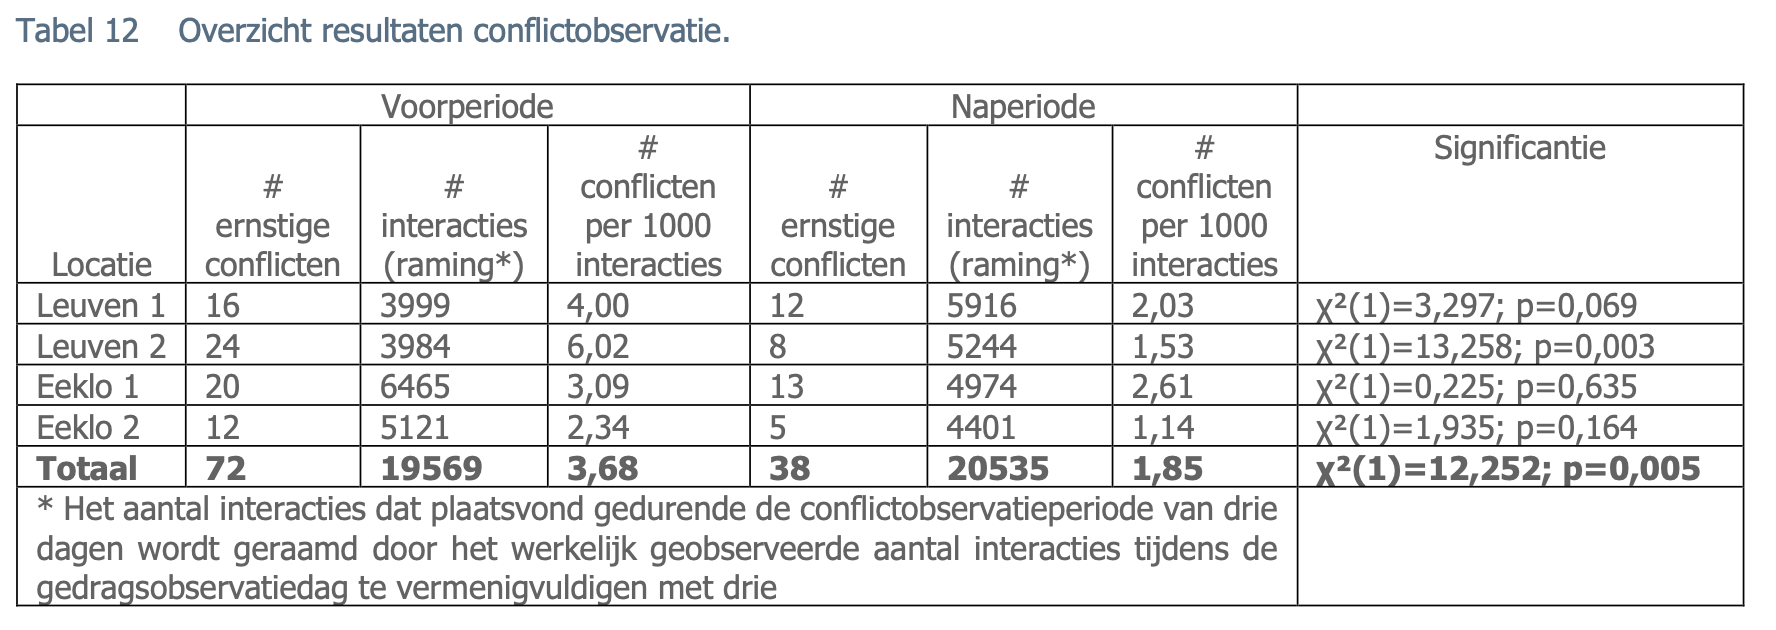

In [16]:
from IPython import display
display.Image("https://i.imgur.com/y0F8703.png")

## $\chi^{2}$ test

In [17]:
from scipy.stats import chi2_contingency
observed = np.array([[72, 19_569-72],
                     [38, 20_535-38]])
chi_val, p_val, dof, expected =  chi2_contingency(observed, correction=False)

chi_val, p_val, dof, expected


(12.251547683986415,
 0.0004648724232305953,
 1,
 array([[   53.67519449, 19515.32480551],
        [   56.32480551, 20478.67519449]]))

# Poisson model for the number of intervention per day

In [18]:
data_leuven_interactions = np.array([3999, 3984, 5916, 5244])
data_leuven_interactions

array([3999, 3984, 5916, 5244])

In [19]:
with pm.Model() as model_conflicts_before:
    alpha_interactions_leuven = 1.0/np.mean(data_leuven_interactions)
    lambda_leuven_interactions = pm.Exponential("leuven_interactions", alpha_interactions_leuven)
    observation = pm.Poisson("obs", lambda_leuven_interactions, observed=data_leuven_interactions)
    trace_leuven_interactions = pm.sample(return_inferencedata=False)
    ppc_leuven_interactions = pm.sample_posterior_predictive(
        trace_leuven_interactions, var_names=["leuven_interactions", "obs"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [leuven_interactions]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Sampling: [leuven_interactions, obs]


In [21]:
# az.summary(trace_leuven_interactions, round_to=2)

ModuleNotFoundError: No module named 'pymc3'

In [22]:
az.__version__

'0.14.0'

In [23]:
az.plot_posterior(trace_leuven_interactions)

ModuleNotFoundError: No module named 'pymc3'

# Estimate the rate of conflicts before intervention

In [ ]:
rates_before = np.array([16/3999, 24/3984])
with pm.Model() as conflict_rate_before:
  p_before = pm.Beta( 'p_before', alpha=(16+24)/2, beta=(3999+3984)/2 )
  rates_before_obs = pm.Binomial("rates_before", p=p_before, n=1, observed=rates_before)
  trace_rates_before = pm.sample(10_000, return_inferencedata=False)

In [ ]:
trace_rates_before

<MultiTrace: 2 chains, 10000 iterations, 2 variables>

In [ ]:
print("before rate day 1= 16/3999 =", 16/3999)
print("before rate day 2= 24/3984 =", 24/3984)

before rate day 1= 16/3999 = 0.004001000250062516
before rate day 2= 24/3984 = 0.006024096385542169


In [ ]:
az.summary(trace_rates_before, round_to=4)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_before,0.005,0.0011,0.003,0.007,0.0,0.0,8186.5964,12203.5297,1.0


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


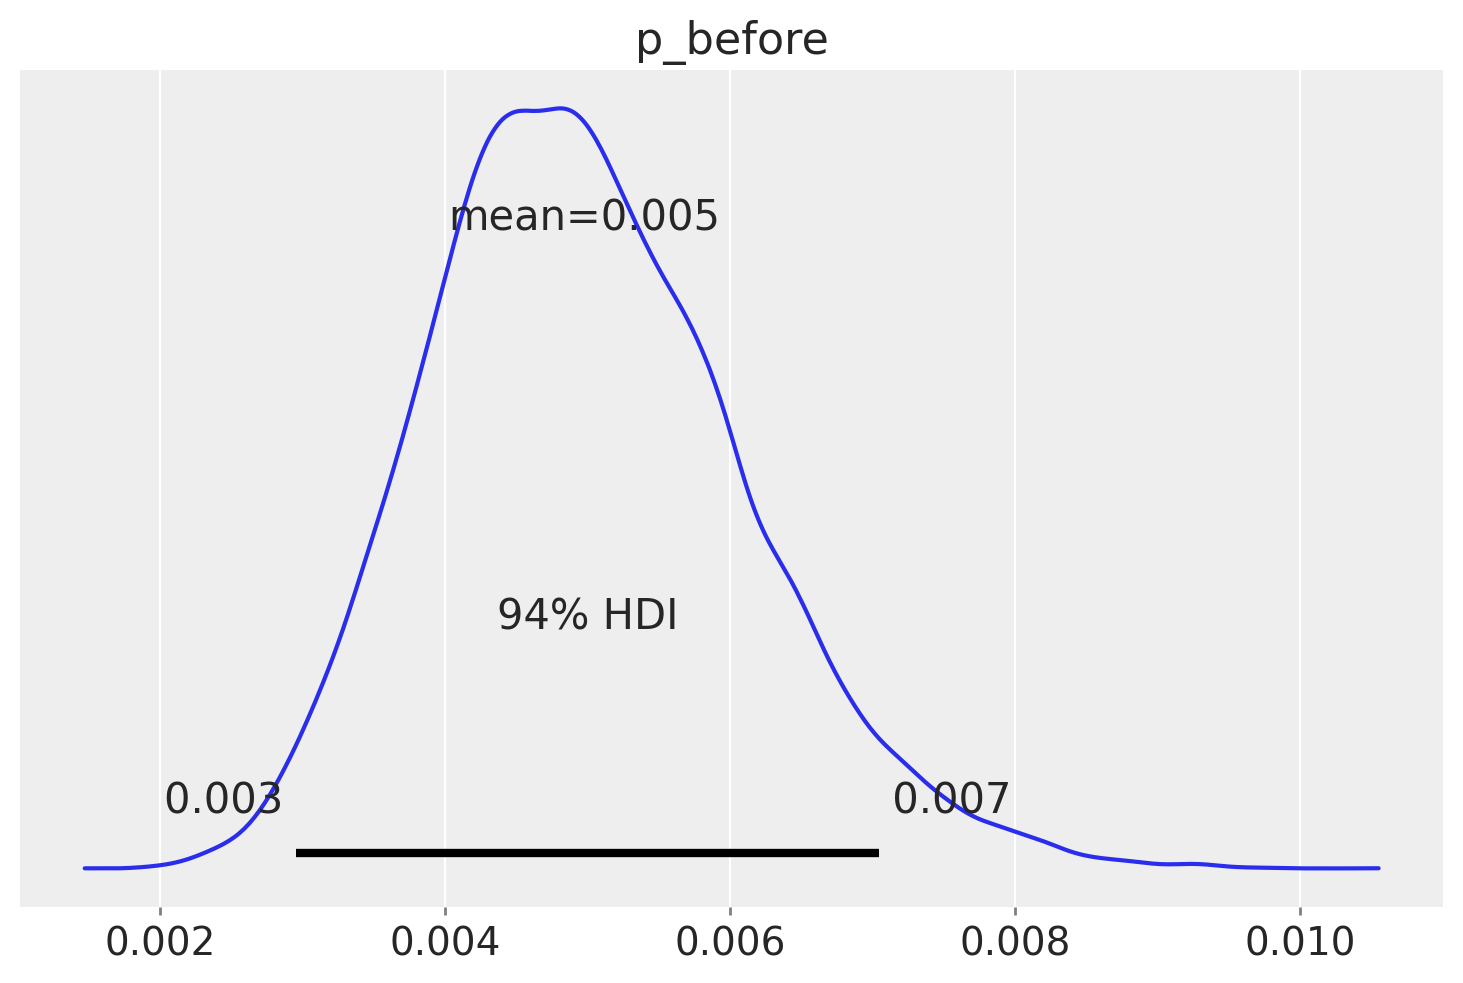

In [ ]:
az.plot_posterior(trace_rates_before)

# Estimate rate of conflicts after intervention

In [ ]:
rates_after = np.array([12/5916, 8/5244])
with pm.Model() as conflict_rate_before:
  p = pm.Beta( 'p', alpha=(12+8)/2, beta=(5916+5244)/2 )
  rates_after_obs = pm.Binomial( 'y_obs', p=p, n=2, observed=rates_after)
  trace_rates_after = pm.sample(10_000, return_inferencedata=False)

In [ ]:
print("After rate day 1= 12/5916 =", 12/5916)
print("After rate day 2= 8/5244 =", 8/5244)

After rate day 1= 12/5916 = 0.002028397565922921
After rate day 2= 8/5244 = 0.0015255530129672007


In [ ]:
az.summary(trace_rates_after, round_to=4)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.0018,0.0006,0.0008,0.0029,0.0,0.0,8225.1187,11312.4087,1.0002


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


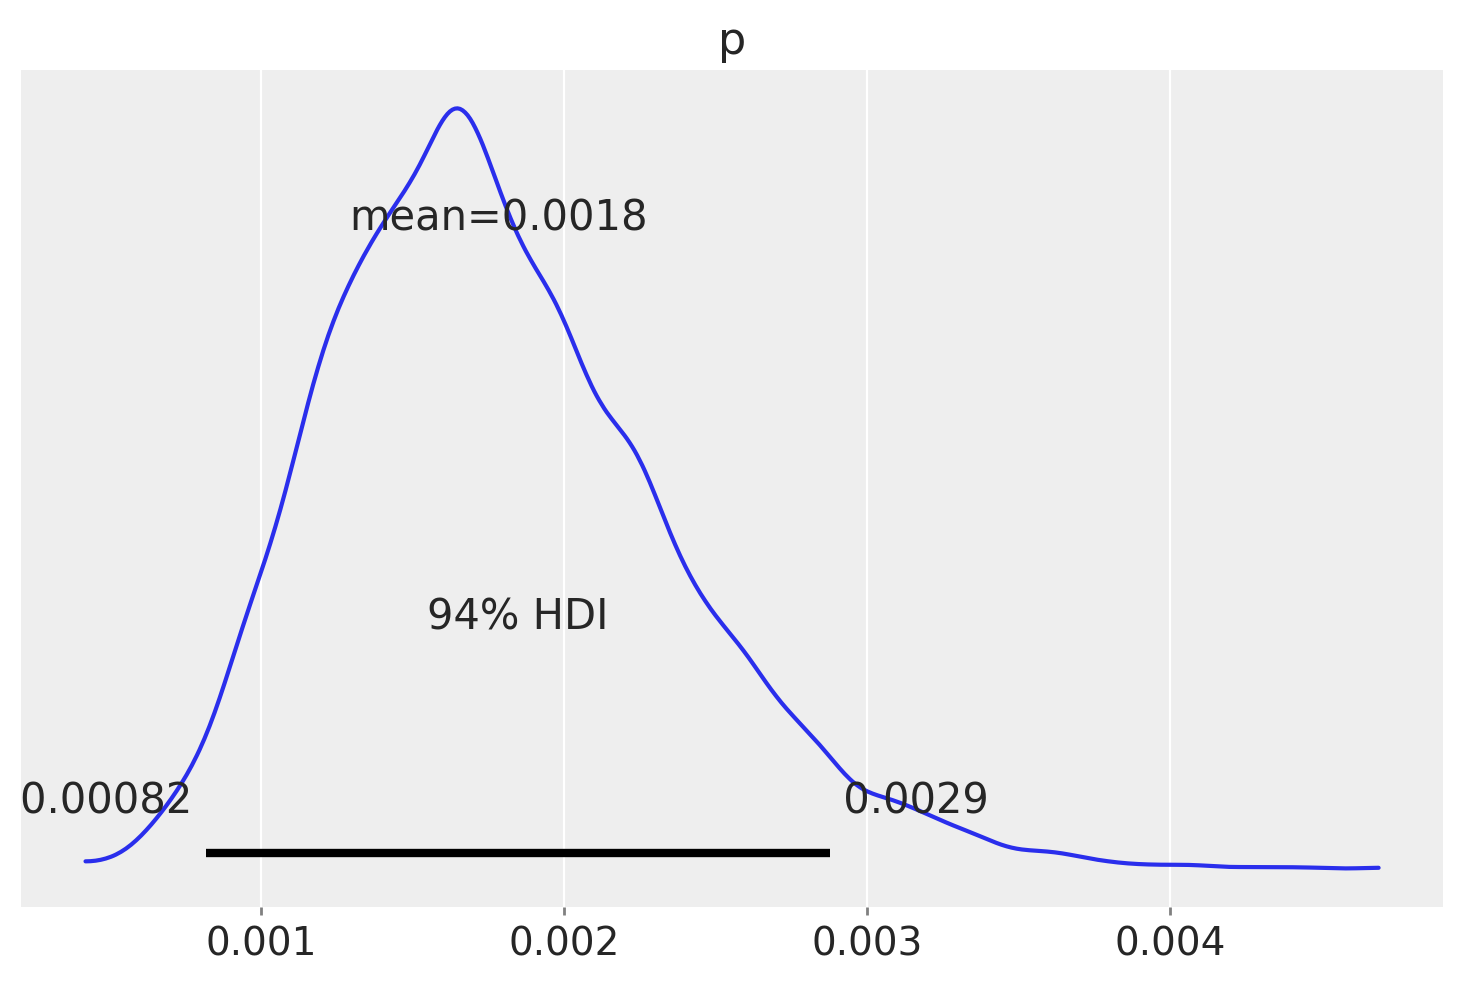

In [ ]:
az.plot_posterior(trace_rates_after)

In [ ]:
trace_rates_before_df = pm.trace_to_dataframe(trace_rates_before)

In [ ]:
trace_rates_before_df

,p_before
0,0.003872
1,0.003676
2,0.003946
3,0.004209
4,0.004209
...,...
19995,0.004813
19996,0.004790
19997,0.004521
19998,0.004521


### Are the rates normally distributed ? Test with Shapiro-Wilkinson test

In [ ]:
from scipy.stats import shapiro

In [ ]:
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
shapiro(trace_rates_before_df["p_before"])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9878184795379639, pvalue=1.1327832220451757e-37)

From [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test): The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population – consequently, a data set with a p value more than the .05 alpha value fails to reject the null hypothesis that the data is from a normally distributed population).[4]

# Bayesian T-Test

https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/BEST.html

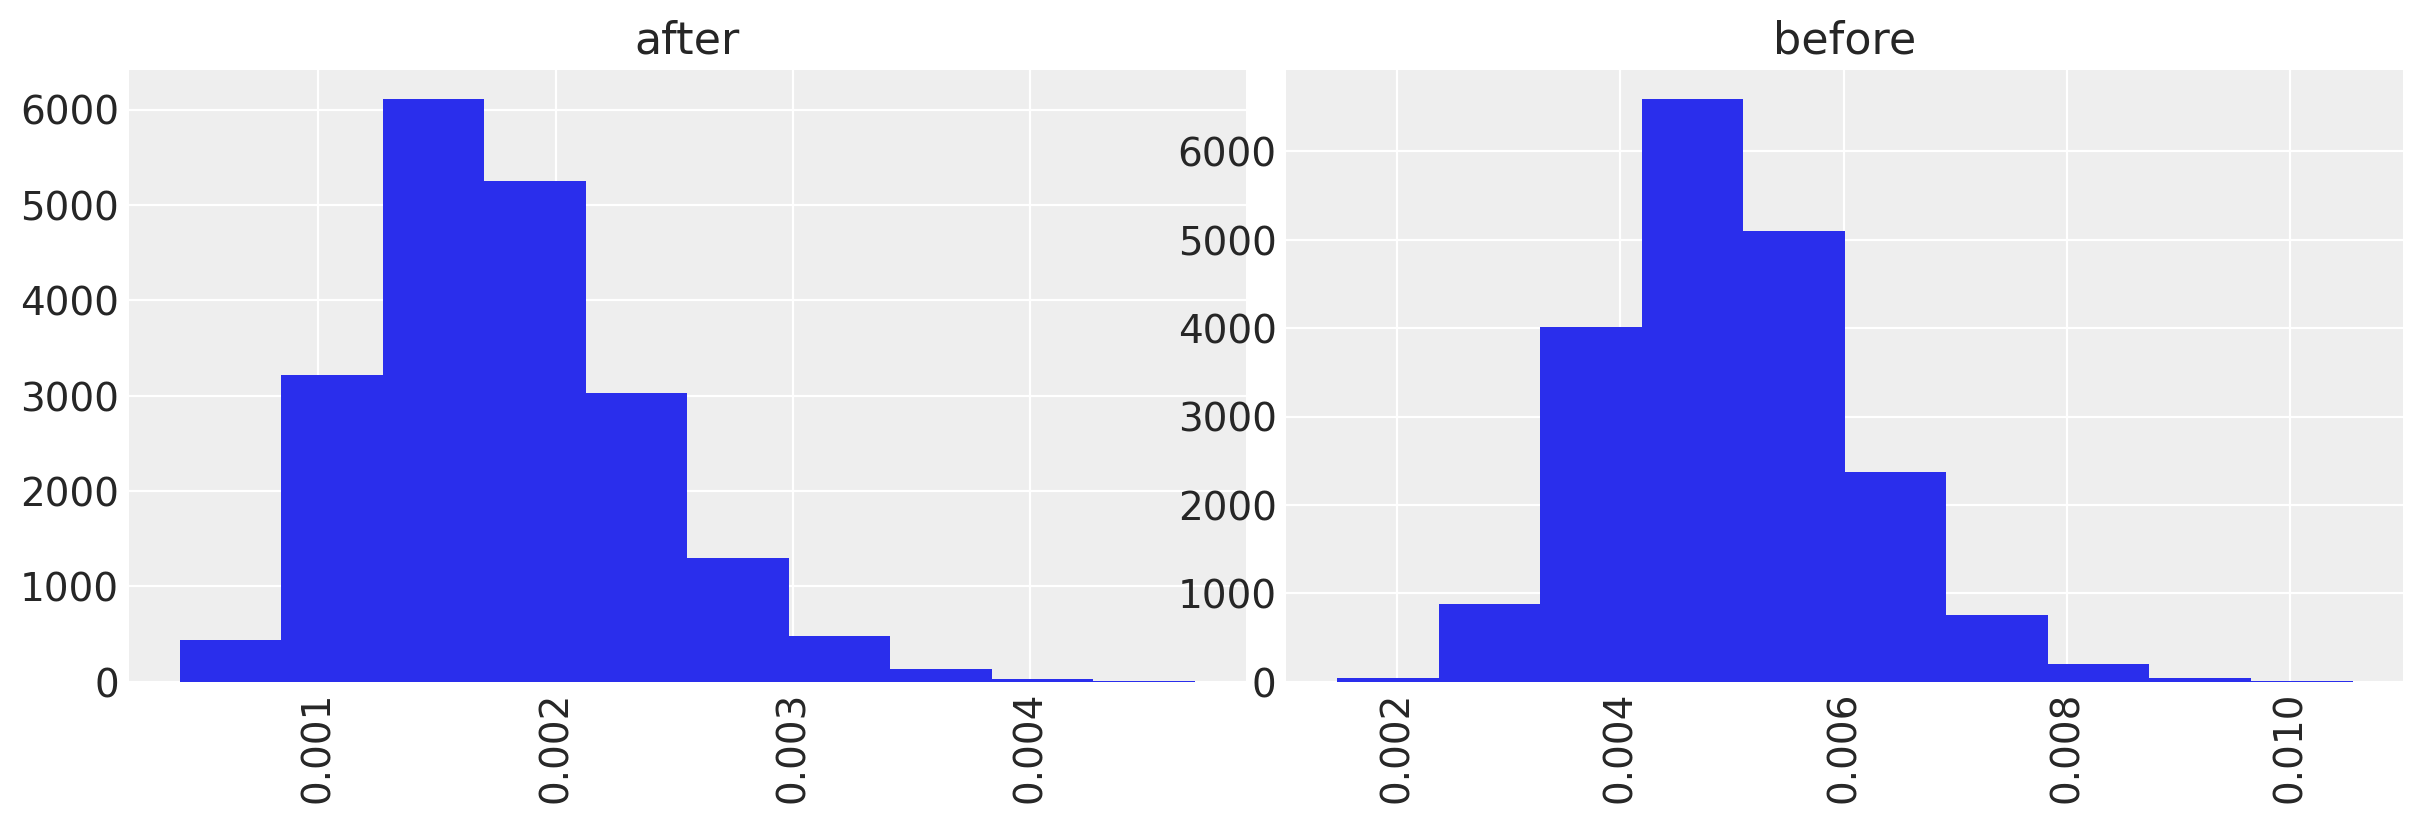

In [ ]:
y1 = pm.trace_to_dataframe(trace_rates_before).values.ravel()
y2 = pm.trace_to_dataframe(trace_rates_after).values.ravel()
y = pd.DataFrame(
    dict(value=np.r_[y1, y2], group=np.r_[["before"] * len(y1), ["after"] * len(y2)])
)

y.hist("value", by="group", figsize=(12, 4));

In [ ]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=μ_m, sigma=μ_s)
    group2_mean = pm.Normal("group2_mean", mu=μ_m, sigma=μ_s)

In [ ]:
σ_low = 0.000000001
σ_high = 10

with model:
    group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)

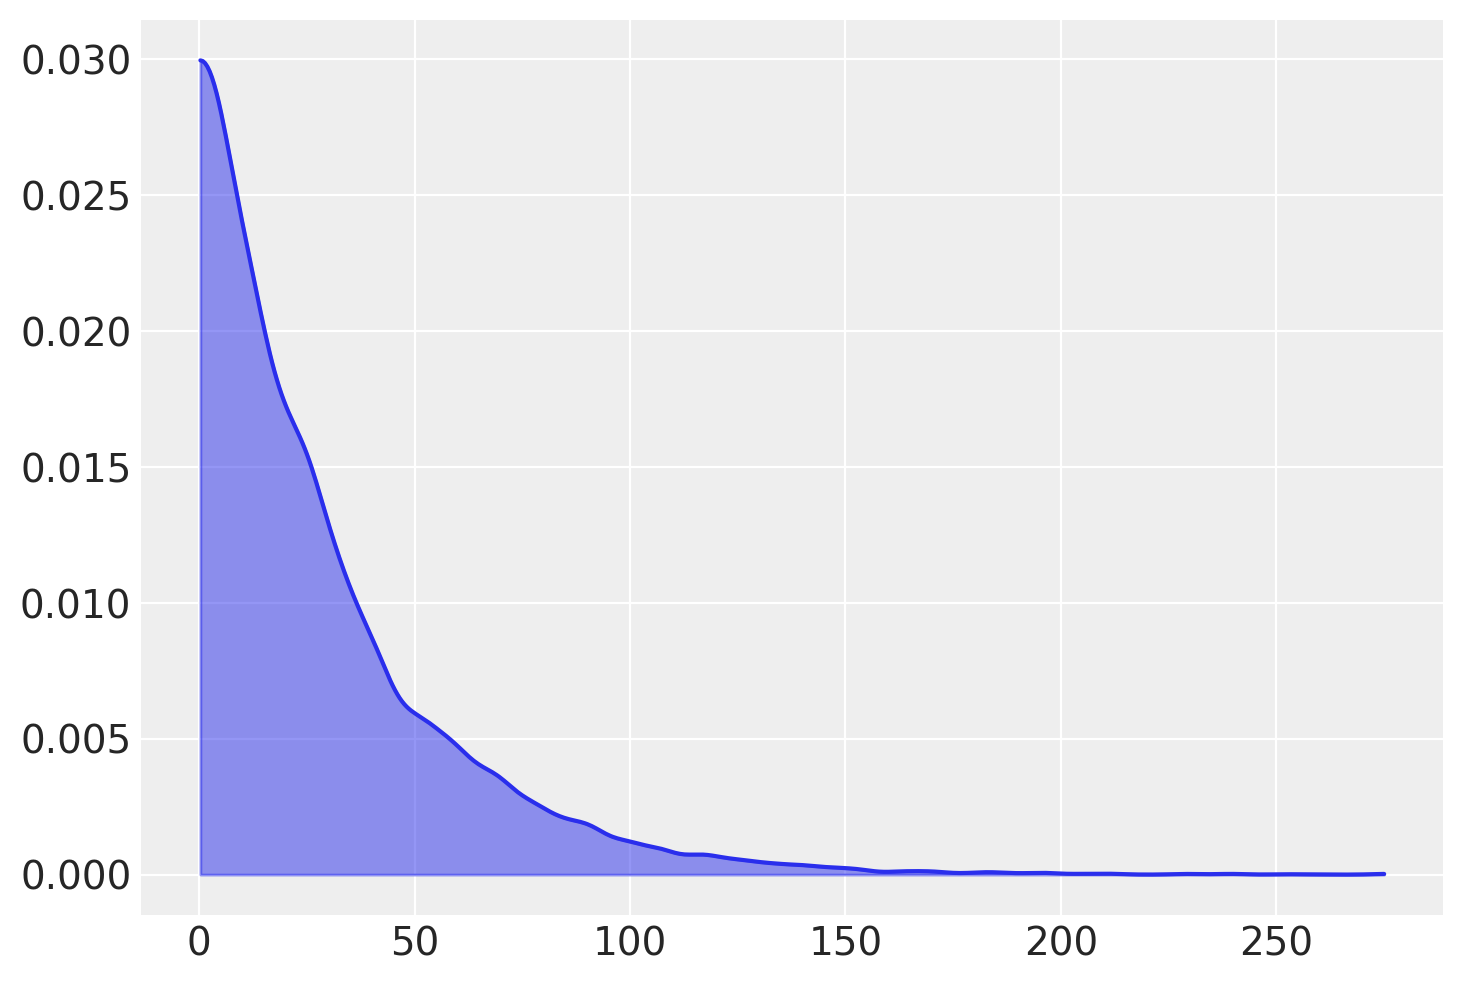

In [ ]:
with model:
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

az.plot_kde(rng.exponential(scale=30, size=10000), fill_kwargs={"alpha": 0.5});

In [ ]:
with model:
    λ1 = group1_std ** -2
    λ2 = group2_std ** -2

    group1 = pm.StudentT("before", nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT("after", nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [ ]:
with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )

In [ ]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

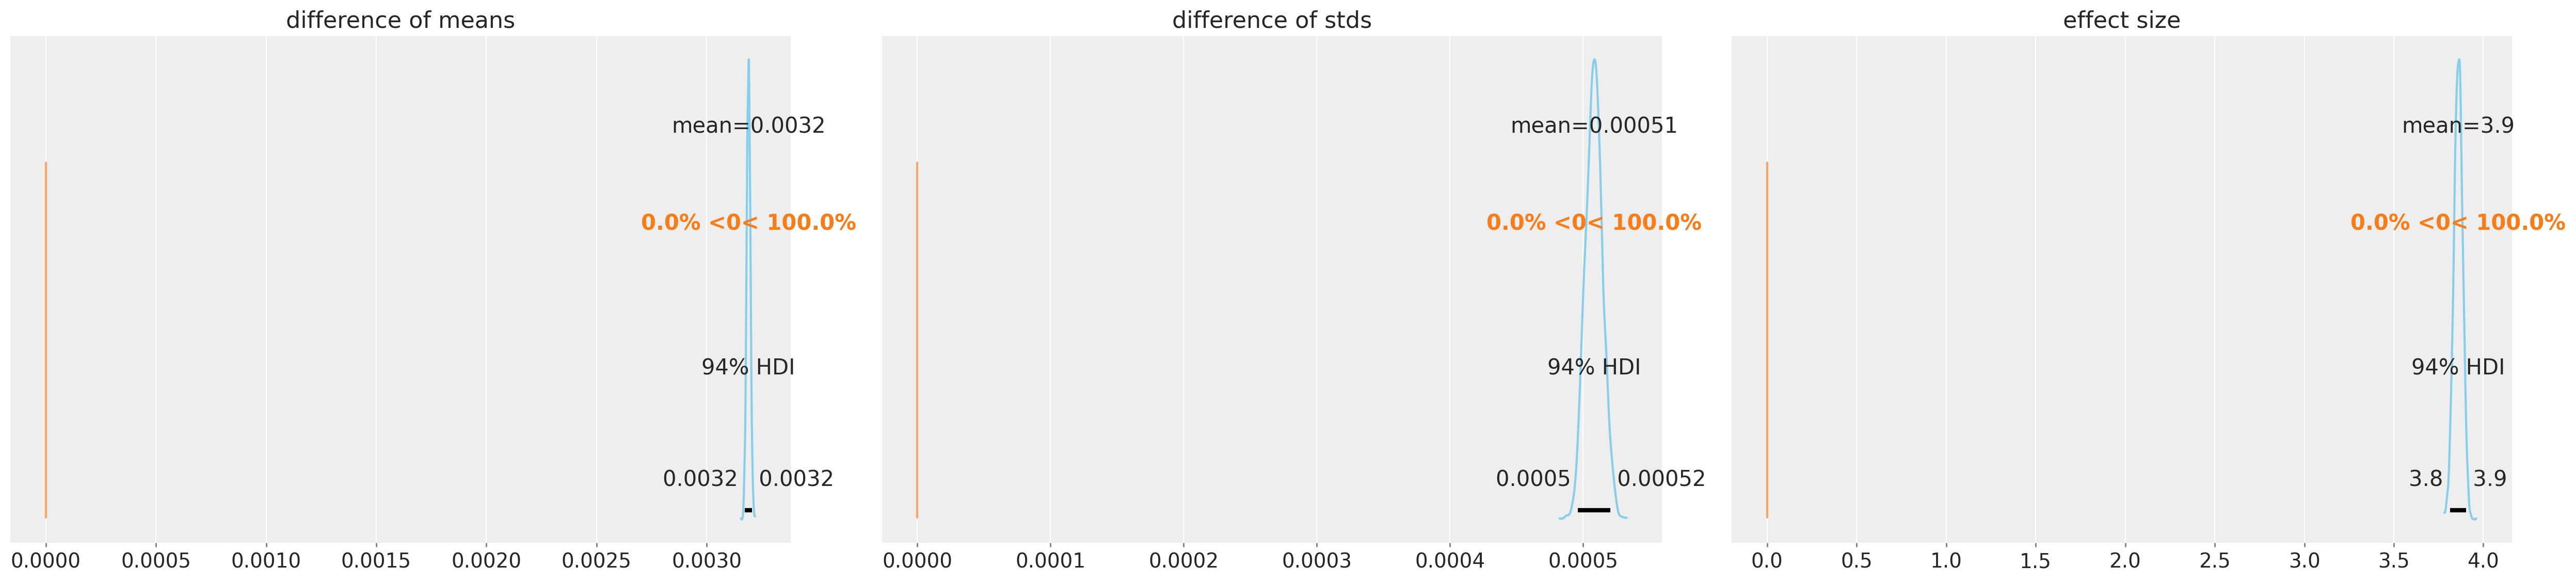

In [ ]:
az.plot_posterior(
    trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

In [ ]:
az.summary(trace, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,0.003,0.000,0.003,0.003,0.0,0.0,3335.0,2750.0,1.0
difference of stds,0.001,0.000,0.000,0.001,0.0,0.0,3980.0,2772.0,1.0
effect size,3.860,0.024,3.813,3.903,0.0,0.0,2702.0,2769.0,1.0


# Bootstrap the amont of times the rate after is smaller

In [ ]:
random_y1_sample = np.random.choice(y1, size=1_000_000, replace=True)
random_y2_sample = np.random.choice(y2, size=1_000_000, replace=True)

In [ ]:
np.mean(random_y1_sample < random_y2_sample)

0.002737